In [1]:
#preparation of the model 

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image
pic_size = 48

# input path for the images
base_path = 'images/'

from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 1

datagen_train = ImageDataGenerator()

total_data = datagen_train.flow_from_directory(base_path + "train/train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Using TensorFlow backend.


Found 87000 images belonging to 29 classes.


In [2]:
import numpy as np
d = np.random.permutation(87000)
# out of 10700 datasets I will be using 80:20 (10000 datasets) for training:validation && 700 for testing
x_train = np.empty((10000, 48, 48, 1), dtype=np.float32)
y_train = np.empty((10000, 29), dtype=np.float32)
x_test = np.empty((700, 48, 48, 1), dtype=np.float32)
y_test = np.empty((700, 29), dtype=np.float32)
for i in range(0,10000):
    x_train[i] = total_data[d[i]][0][0]
    y_train[i] = total_data[d[i]][1][0]
for i in range(10000,10700):
    x_test[i-10000] = total_data[d[i]][0][0] 
    y_test[i-10000] = total_data[d[i]][1][0] 
    

(700, 48, 48)


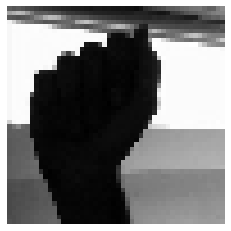

In [3]:
# Defining Image Computations 
def plot_image(i):
    image = x_test[i]
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
x_test.resize((700,48,48)) 
## Printing the shape of the hands
print(x_test.shape)

## Plotting 1 image
plot_image(13)


plot_image(16)

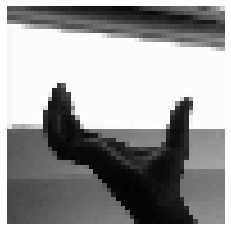

In [4]:
## Plotting second image
plot_image(16)

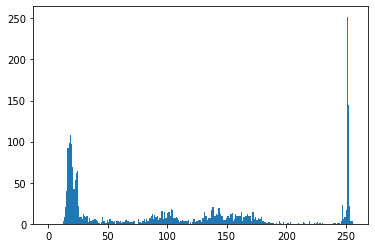

In [5]:
# Let's plot histogram for 2 images to see the sharp differences between the images
import cv2
def plot_histogram(i):
    img = x_test[i]
    plt.hist(img.ravel(),256,[0,256]) 
    plt.show() 
plot_histogram(13)

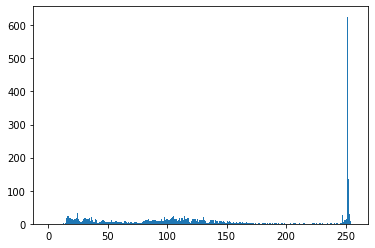

In [6]:
plot_histogram(16)

<Figure size 432x288 with 0 Axes>

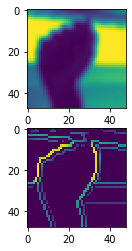

In [9]:
import numpy as np 
import os 
import cv2 
import matplotlib.pyplot as plt 
  
   
# defining the canny detector function 
   
# here weak_th and strong_th are thresholds for 
# double thresholding step 
def Canny_detector(i, weak_th = None, strong_th = None): 
    img = x_test[i]
    # conversion of image to grayscale 
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
       
    # Noise reduction step 
    img = cv2.GaussianBlur(img, (5, 5), 1.4) 
       
    # Calculating the gradients 
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3) 
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3) 
      
    # Conversion of Cartesian coordinates to polar  
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True) 
       
    # setting the minimum and maximum thresholds  
    # for double thresholding 
    mag_max = np.max(mag) 
    if not weak_th:weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5
      
    # getting the dimensions of the input image   
    height, width = img.shape 
       
    # Looping through every pixel of the grayscale  
    # image 
    for i_x in range(width): 
        for i_y in range(height): 
               
            grad_ang = ang[i_y, i_x] 
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang) 
               
            # selecting the neighbours of the target pixel 
            # according to the gradient direction 
            # In the x axis direction 
            if grad_ang<= 22.5: 
                neighb_1_x, neighb_1_y = i_x-1, i_y 
                neighb_2_x, neighb_2_y = i_x + 1, i_y 
              
            # top right (diagnol-1) direction 
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45): 
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
              
            # In y-axis direction 
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90): 
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
              
            # top left (diagnol-2) direction 
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135): 
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1
              
            # Now it restarts the cycle 
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180): 
                neighb_1_x, neighb_1_y = i_x-1, i_y 
                neighb_2_x, neighb_2_y = i_x + 1, i_y 
               
            # Non-maximum suppression step 
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0: 
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]: 
                    mag[i_y, i_x]= 0
                    continue
   
            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0: 
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]: 
                    mag[i_y, i_x]= 0
   
    weak_ids = np.zeros_like(img) 
    strong_ids = np.zeros_like(img)               
    ids = np.zeros_like(img) 
       
    # double thresholding step 
    for i_x in range(width): 
        for i_y in range(height): 
              
            grad_mag = mag[i_y, i_x] 
              
            if grad_mag<weak_th: 
                mag[i_y, i_x]= 0
            elif strong_th>grad_mag>= weak_th: 
                ids[i_y, i_x]= 1
            else: 
                ids[i_y, i_x]= 2
    
    plt.figure() 
    f, plots = plt.subplots(2, 1)  
    plots[0].imshow(img) 
    plots[1].imshow(mag)   
    
Canny_detector(13)   
   
# # Displaying the input and output image   
# plt.figure() 
# f, plots = plt.subplots(2, 1)  
# plots[0].imshow(frame) 
# plots[1].imshow(canny_img)

In [ ]:
# After This we will train the model & augment the data